Ref: https://ieeexplore.ieee.org/document/6669575   (Nonlinear Model Predictive Control using Feedback Linearization and Local Inner Convex Constraint Approximations)

In [1]:
import numpy as np
import casadi as ca
import matplotlib.pyplot as plt

#### System model 

$\begin{aligned} \dot{\alpha} &=-k_{1} \alpha+k_{2} q \\ \dot{q} &=k_{3} \alpha^{2}+k_{4} \alpha-k_{5} q+k_{6} \delta_{e} \\ y &=\alpha \end{aligned}$

#### System after transformation

$\begin{aligned} \dot{\alpha} &=-k_{1} \alpha+k_{2} q \\ \dot{q} &=k_{4} \alpha-k_{5} q+k_{6} \tilde{u} \end{aligned}$

and

$\delta_{e}=\tilde{u}-\frac{k_{3}}{k_{6}} \alpha^{2}$

#### System model 
$$
    \dot{x}_1 = x_{2}, \quad \dot{x}_2 = -\frac{k_2}{m} x_{1}^{3} - \frac{k_1}{m}x_2 + \frac{1}{m} u 
$$

#### System after transformation

$$
    \dot{x}_1 = x_{2}, \quad \dot{x}_2 = \nu - \frac{k_1}{m}x_2  
$$

and $u = k_2 x_1^3 + m \nu$; hence $\nu =( u - k_2 x_1^3 )/m$

In [2]:
def integrator_rk4(f, x, u, delta_t):
        '''
        This function calculates the integration of stage cost with RK4.
        '''

        k1 = f(x, u)
        k2 = f(x + delta_t / 2 * k1, u)
        k3 = f(x + delta_t / 2 * k2, u)
        k4 = f(x + delta_t * k3, u)

        x_next = x + delta_t / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
        return x_next

In [3]:
m = 2  # [kg]
k1 = 3  # [N/m]
k2 = 2  # [N/m]


In [4]:
def nonlinear_ode(x, u):

    #     A = ca.DM([[0, 1], [-k2 / m, -k1 / m]])
    #     B = ca.DM([[0], [1 / m]])

    x1p = x[1]
    x2p = -k2 / m * x[0] ** 3 - k1 / m * x[1] + 1 / m * u[0]

    rhs = [x1p,
           x2p
           ]

    return ca.vertcat(*rhs)

In [5]:
def linear_ode(x, nu):

    #     A = ca.DM([[0, 1], [-k2 / m, -k1 / m]])
    #     B = ca.DM([[0], [1 / m]])

    x1p = x[1]
    x2p = nu - k1 / m * x[1] 

    rhs = [x1p,
           x2p
           ]

    return ca.vertcat(*rhs)

#### Traj simulation

In [6]:
x_SX = ca.SX.sym("x_SX", 2)
u_SX = ca.SX.sym("u_SX", 1)
nu_SX = ca.SX.sym("nu_SX", 1)

ode_nonlinear = ca.Function("ode_func", [x_SX, u_SX], [nonlinear_ode(x_SX, u_SX)])
ode_linear = ca.Function("ode_func", [x_SX, u_SX], [linear_ode(x_SX, nu_SX)])
delta_t = 0.1

In [7]:
sys_nonlinear_int = integrator_rk4(ode_nonlinear, x_SX, u_SX, delta_t)
sys_nonlinear_int_fn = ca.Function("sys_nonlinear_int_fn",[x_SX, u_SX],[sys_nonlinear_int])

sys_linear_int = integrator_rk4(ode_linear, x_SX, nu_SX, delta_t)
sys_linear_int_fn = ca.Function("sys_linear_int_fn",[x_SX, nu_SX],[sys_linear_int])

In [8]:
nu_func = ca.Function("nu_func",[x_SX, u_SX],[(u_SX -k2 * x_SX[0]**3)/m])
u_func = ca.Function("nu_func",[x_SX, nu_SX],[k2 * x_SX[0]**3 + m * nu_SX])

In [9]:
N = 50

x_init = np.array([[-2.],[0.]])

In [10]:
x_list1 = []
x_list1.append(x_init.flatten().tolist())

In [11]:
uk = np.array([[0.]])
xk = x_init
for i in range(N):
    x_next = sys_nonlinear_int_fn(xk,uk)
    x_list1.append(x_next.full().flatten().tolist())
    x0 = xk
    xk = x_next

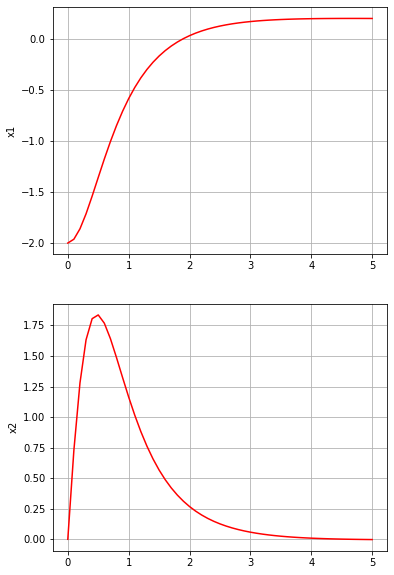

In [12]:
x_plot = np.array(x_list1)
N_plot = N
tgrid = [delta_t * k for k in range(N_plot + 1)]
plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (2):
    plt.subplot(2,1,i + 1)
    plt.grid()
    x_opt = x_plot[:N_plot+1,i]
    plt.plot(tgrid, x_opt, 'r')
    plt.ylabel('x' + str(i + 1))

In [13]:
x_list2 = []
x_list2.append(x_init.flatten().tolist())

In [14]:
nu_k = np.array([[0.]])
xk = x_init
for i in range(N):
    x_next = sys_linear_int_fn(xk,nu_k)
    x_list2.append(x_next.full().flatten().tolist())
    x0 = xk
    xk = x_next

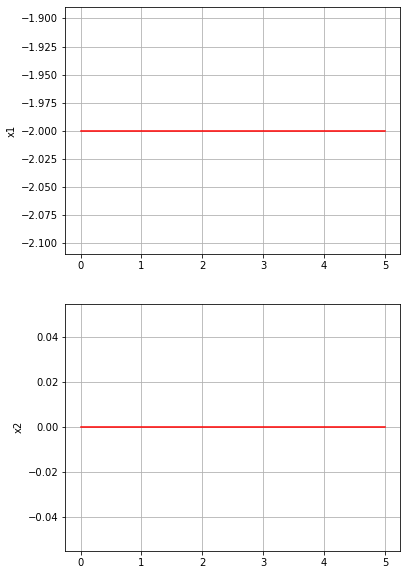

In [15]:
x_plot = np.array(x_list2)
N_plot = N
tgrid = [delta_t * k for k in range(N_plot + 1)]
plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (2):
    plt.subplot(2,1,i + 1)
    plt.grid()
    x_opt = x_plot[:N_plot+1,i]
    plt.plot(tgrid, x_opt, 'r')
    plt.ylabel('x' + str(i + 1))

In [16]:
x_list3 = []
x_list3.append(x_init.flatten().tolist())

In [17]:
nu_k = np.array([[0.]])
xk = x_init
for i in range(N):
    nu_k = nu_func(xk, 0)
    x_next = sys_linear_int_fn(xk,nu_k)
    x_list3.append(x_next.full().flatten().tolist())
    x0 = xk
    xk = x_next

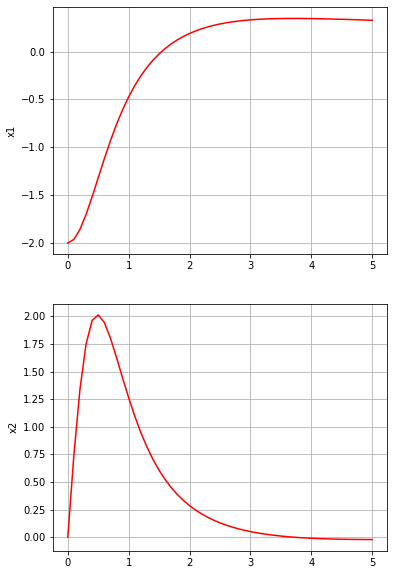

In [18]:
x_plot = np.array(x_list3)
N_plot = N
tgrid = [delta_t * k for k in range(N_plot + 1)]
plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (2):
    plt.subplot(2,1,i + 1)
    plt.grid()
    x_opt = x_plot[:N_plot+1,i]
    plt.plot(tgrid, x_opt, 'r')
    plt.ylabel('x' + str(i + 1))

### OCP 
Nonlinear model

In [19]:
Nx = 2
Nu = 1
N_nu = 1
N_pred = 5

In [20]:
obj = 0

g = []

Q = ca.diag([10,1])
R = ca.diag([1])

x0_SX = ca.SX.sym("x0_SX", Nx)

obj = 0

xk_dec_list = []
uk_dec_list = []
for i in range(N_pred):
    xi_var = ca.SX.sym('x_' + str(i + 1), Nx)
    ui_var = ca.SX.sym('u_' + str(i + 1), Nu)
    uk = ui_var
    xk = xi_var
    
    obj +=  xk.T @ Q @ xk + uk.T @ R @ uk
    if i == 0:
        g += [xk - x0_SX]
    else:
        g += [xk - sys_nonlinear_int_fn(xk_pre,uk_pre)]
        
    xk_pre = xk
    uk_pre = uk

    xk_dec_list += [xk]
    uk_dec_list += [uk]
    
xf = ca.SX.sym('x_' + str(N_pred), Nx)
obj += xf.T @ Q @ xf
g += [xf - sys_nonlinear_int_fn(xk_pre,uk_pre)]

xk_dec_list += [xf]

p = [x0_SX]

In [21]:
ca.vertcat(*(xk_dec_list+uk_dec_list))

SX([x_1_0, x_1_1, x_2_0, x_2_1, x_3_0, x_3_1, x_4_0, x_4_1, x_5_0, x_5_1, x_5_0, x_5_1, u_1, u_2, u_3, u_4, u_5])

In [22]:
nlp_prob = {
    'f': obj,
    'x': ca.vertcat(*(xk_dec_list+uk_dec_list)),
    'g': ca.vertcat(*g),
    'p': ca.vertcat(*p)
}

In [23]:
solver_opt = {}
solver_opt['print_time'] = False
solver_opt['ipopt'] = {
    'max_iter': 500,
    'print_level': 1,
    'acceptable_tol': 1e-6,
    'acceptable_obj_change_tol': 1e-6
}

solver = ca.nlpsol("solver", "ipopt", nlp_prob, solver_opt)

In [62]:
solver.info

<bound method Function.info of Function(solver:(x0[17],p[2],lbx[17],ubx[17],lbg[12],ubg[12],lam_x0[17],lam_g0[12])->(x[17],f,g[12],lam_x[17],lam_g[12],lam_p[2]) IpoptInterface)>

In [74]:
np.shape(solver.sx_in(0))

(17, 1)

In [25]:
x_trajectory = []
u_trajectory = []

N_sim = 120

In [26]:
x_init = [-2.,0.]
nl = {}
nl['x0'] = [0] * Nx * (N_pred + 1)  + [0] * Nu * N_pred
nl['lbx'] = [-ca.inf, -ca.inf] * (N_pred + 1) +  [-ca.inf] * N_pred
nl['ubx'] = [ca.inf, 0.5] * (N_pred + 1) +  [ca.inf] * N_pred
nl['lbg'] = [0, 0] * (N_pred + 1) 
nl['ubg'] = [0, 0] * (N_pred + 1) 
# nl['p'] = [x0]

xk = x_init
x_trajectory = []
x_trajectory += xk

Nx_total = Nx * (N_pred + 1)

# Start simulation
for i in range(N_sim):
    print(xk)
    nl['p'] = xk
    sol = solver(**nl)
    sol_opt = sol['x'].full().flatten()

    # Find optimal input
    opt_u = sol_opt[Nx_total : Nx_total + Nu].tolist()
#     print(sol_opt)
    u_trajectory += opt_u

    # Apply the optimal input to the real system
    x_next_real = sys_nonlinear_int_fn(xk,opt_u)
    x_trajectory += x_next_real.full().flatten().tolist()    #  ca.DM -> list

    # Update solver
    xk = x_next_real
    nl['x0'] = sol_opt

#     nl['lbx'][:Nx] = x_next_real.full().flatten().tolist()
#     nl['ubx'][:Nx] = x_next_real.full().flatten().tolist()


[-2.0, 0.0]

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

[-1.97633, 0.457418]
[-1.92795, 0.5]
[-1.8775, 0.5]
[-1.82707, 0.5]
[-1.77667, 0.5]
[-1.72628, 0.5]
[-1.67592, 0.5]
[-1.62558, 0.5]
[-1.57526, 0.5]
[-1.52496, 0.5]
[-1.47468, 0.5]
[-1.42442, 0.5]
[-1.37417, 0.5]
[-1.32394, 0.5]
[-1.27373, 0.5]
[-1.22354, 0.5]
[-1.17336, 0.5]
[-1.12319, 0.5]
[-1.07304, 0.5]
[-1.02291, 0.5]
[-0.972781, 0.5]
[-0.922669, 0.5]
[-0.872568, 0.5]
[-0.822542, 0.49875]
[-0.773165, 0.487502]
[-0.725295, 0.469002]
[-0.679539, 0.445574]
[-0.636292, 0.419107]
[-0.595779, 0.391085]
[-0.558097, 0.362636]
[-0.523245, 0.334585]
[-0.491154, 0.307512]
[-0.461703, 0.281801]
[-0.43

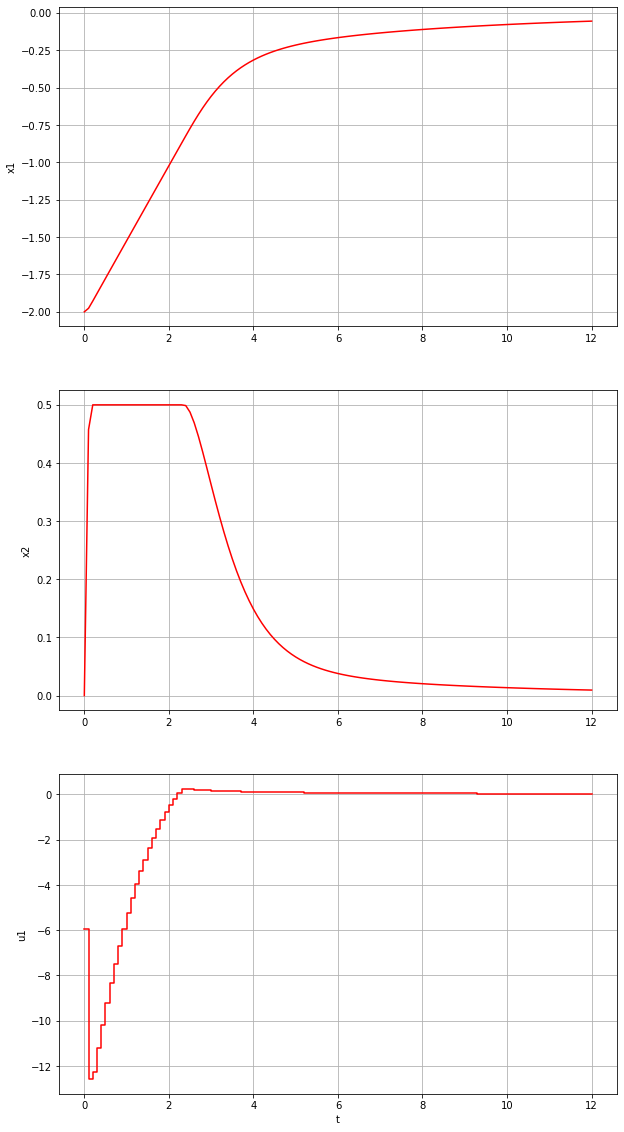

In [27]:
# Plot

# Plot the solution
tgrid = [delta_t * k for k in range(N_sim + 1)]

plt.figure(1, figsize=(10, 20))
plt.clf()
for i in range (Nx):
    plt.subplot(Nx + Nu,1, i + 1)
    plt.grid()
    x_opt = x_trajectory[i::Nx]
    plt.plot(tgrid, x_opt, 'r')
    plt.ylabel('x' + str(i + 1))

for i in range(Nu):
    plt.subplot(Nx + Nu, 1, Nx + i + 1)
    plt.grid()
    u_opt = u_trajectory[i::Nu]
    plt.step(tgrid, ca.vertcat(ca.DM.nan(1), u_opt), 'r')
    plt.ylabel('u' + str(i + 1))
plt.xlabel('t')
plt.show()

Feedback linearization

In [28]:
obj = 0

g = []

Q = ca.diag([10,1])
R = ca.diag([1])

x0_SX = ca.SX.sym("x0_SX", Nx)

obj = 0

xk_dec_list = []
nuk_dec_list = []
for i in range(N_pred):
    xi_var = ca.SX.sym('x_' + str(i + 1), Nx)
    nui_var = ca.SX.sym('nu_' + str(i + 1), N_nu)
    nuk = nui_var
    xk = xi_var
    
    obj +=  xk.T @ Q @ xk + nuk.T @ R @ nuk
    if i == 0:
        g += [xk - x0_SX]
    else:
        g += [xk - sys_linear_int_fn(xk_pre,nuk_pre)]
        
    xk_pre = xk
    nuk_pre = nuk

    xk_dec_list += [xk]
    nuk_dec_list += [nuk]
    
xf = ca.SX.sym('x_' + str(N_pred), Nx)
obj += xf.T @ Q @ xf
g += [xf - sys_linear_int_fn(xk_pre,nuk_pre)]

xk_dec_list += [xf]

p = [x0_SX]

In [29]:
ca.vertcat(*(xk_dec_list+nuk_dec_list))

SX([x_1_0, x_1_1, x_2_0, x_2_1, x_3_0, x_3_1, x_4_0, x_4_1, x_5_0, x_5_1, x_5_0, x_5_1, nu_1, nu_2, nu_3, nu_4, nu_5])

In [30]:
nlp_prob = {
    'f': obj,
    'x': ca.vertcat(*(xk_dec_list+nuk_dec_list)),
    'g': ca.vertcat(*g),
    'p': ca.vertcat(*p)
}

In [31]:
solver_opt = {}
solver_opt['print_time'] = False
solver_opt['ipopt'] = {
    'max_iter': 500,
    'print_level': 1,
    'acceptable_tol': 1e-6,
    'acceptable_obj_change_tol': 1e-6
}

solver =  ca.qpsol('solver', 'qpoases', nlp_prob, {'sparse':True})
# solver = ca.nlpsol("solver", "ipopt", nlp_prob, solver_opt)

In [32]:
solver.info

<bound method Function.info of Function(solver:(x0[17],p[2],lbx[17],ubx[17],lbg[12],ubg[12],lam_x0[17],lam_g0[12])->(x[17],f,g[12],lam_x[17],lam_g[12],lam_p[2]) MXFunction)>

In [33]:
x_trajectory = []
nu_trajectory = []
u_trajectory = []

N_sim = 100

In [34]:
x_init = [-2.,0.]
nl = {}
nl['x0'] = [0] * Nx * (N_pred + 1)  + [0] * N_nu * N_pred
nl['lbx'] = [-ca.inf, -ca.inf] * (N_pred + 1) +  [-ca.inf] * N_pred
nl['ubx'] = [ca.inf, 0.5] * (N_pred + 1) +  [ca.inf] * N_pred
nl['lbg'] = [0, 0] * (N_pred + 1) 
nl['ubg'] = [0, 0] * (N_pred + 1) 
# nl['p'] = [x0]

xk = x_init
x_trajectory = []
x_trajectory += xk

Nx_total = Nx * (N_pred + 1)

# Start simulation
for i in range(N_sim):
    print(xk)
    nl['p'] = xk
    sol = solver(**nl)
    sol_opt = sol['x'].full().flatten()

    # Find optimal input
    opt_nu = sol_opt[Nx_total : Nx_total + N_nu].tolist()
    print(sol_opt)
    nu_trajectory += opt_nu
    
    opt_u = u_func(xk, opt_nu)
    u_trajectory += opt_u.full().flatten().tolist()
    
    # Apply the optimal input to the real system
    x_next_real = sys_nonlinear_int_fn(xk,opt_u)
    x_trajectory += x_next_real.full().flatten().tolist()    #  ca.DM -> list

    # Update solver
    xk = x_next_real
    nl['x0'] = sol_opt

#     nl['lbx'][:Nx] = x_next_real.full().flatten().tolist()
#     nl['ubx'][:Nx] = x_next_real.full().flatten().tolist()


[-2.0, 0.0]


####################   qpOASES  --  QP NO.   1   #####################

    Iter   |    StepLength    |       Info       |   nFX   |   nAC    
 ----------+------------------+------------------+---------+--------- 
       0   |   2.792244e-08   |   REM BND   10   |    16   |     0   
       1   |   7.228030e-11   |   REM BND    8   |    15   |     0   
       2   |   7.545746e-11   |   REM BND    6   |    14   |     0   
       3   |   7.884881e-11   |   REM BND    4   |    13   |     0   
       4   |   8.247404e-11   |   REM BND    2   |    12   |     0   
       5   |   8.635517e-11   |   REM BND    0   |    11   |     0   
       6   |   2.489098e-07   |   REM BND   16   |    10   |     0   
       7   |   3.161368e-10   |   REM BND   15   |     9   |     0   
       8   |   3.225234e-10   |   REM BND   14   |     8   |     0   
       9   |   3.291055e-10   |   REM BND   13   |     7   |     0   
      10   |   3.358912e-10   |   REM BND   12   |     6   |     0   
  

### Remark for feedback linearization
1. If delta_t = 0.1 and N_pred = 5, upper bound for x2 would not be reached.
1. If delta_t = 0.05 and N_pred = 10, upper bound for x2 is reached. Behave as the closed-loop for the nonlinear model.

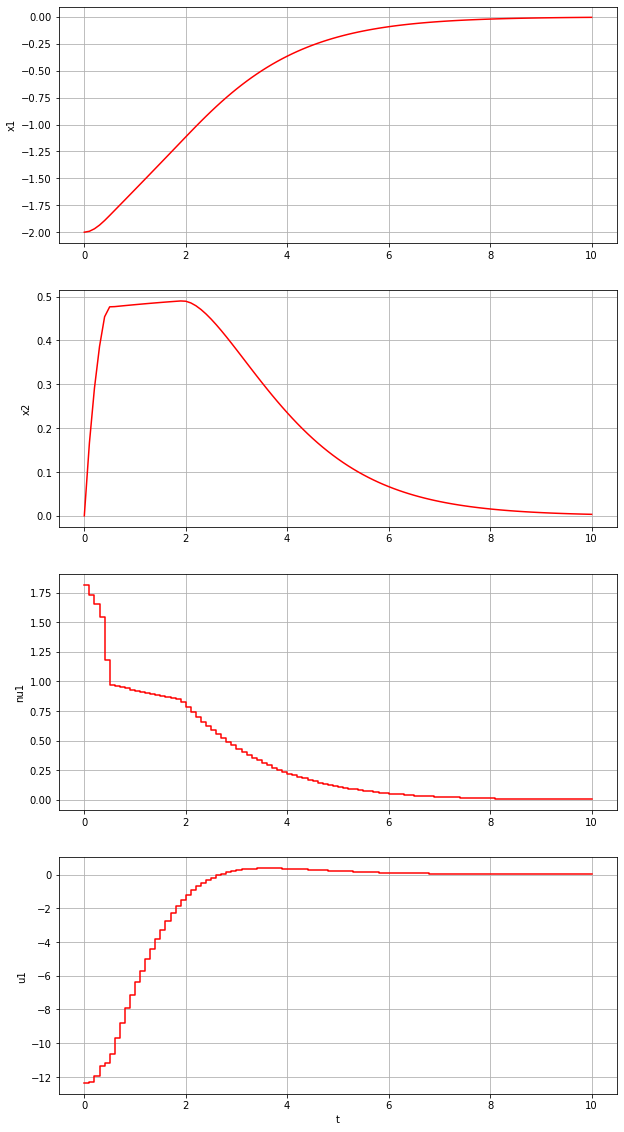

In [35]:
# Plot

# Plot the solution
tgrid = [delta_t * k for k in range(N_sim + 1)]

plt.figure(1, figsize=(10, 20))
plt.clf()
for i in range (Nx):
    plt.subplot(Nx + Nu + N_nu,1, i + 1)
    plt.grid()
    x_opt = x_trajectory[i::Nx]
    plt.plot(tgrid, x_opt, 'r')
    plt.ylabel('x' + str(i + 1))

for i in range(N_nu):
    plt.subplot(Nx + Nu + N_nu, 1, Nx + i + 1)
    plt.grid()
    nu_opt = nu_trajectory[i::N_nu]
    plt.step(tgrid, ca.vertcat(ca.DM.nan(1), nu_opt), 'r')
    plt.ylabel('nu' + str(i + 1))    
    
    
for i in range(Nu):
    plt.subplot(Nx + Nu + N_nu, 1, Nx + N_nu + i + 1)
    plt.grid()
    u_opt = u_trajectory[i::Nu]
    plt.step(tgrid, ca.vertcat(ca.DM.nan(1), u_opt), 'r')
    plt.ylabel('u' + str(i + 1))
plt.xlabel('t')
plt.show()

### Visualize input constraint w.r.t. state

$u = k_2 x_1^3 + m \nu$

$v=\left(u-k_{2} x_{1}^{3}\right) / m$ and let $-1 \le u \le 1$

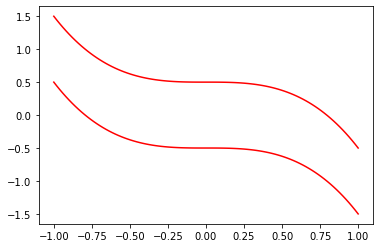

In [77]:
# 100 linearly spaced numbers
x = np.linspace(-1,1,100)

# the function
y1 = (-1 - k2 * x**3)/m
y2 = (1 - k2 * x**3)/m

# setting the axes at the centre
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
# ax.spines['left'].set_position('center')
# ax.spines['bottom'].set_position('zero')
# ax.spines['right'].set_color('none')
# ax.spines['top'].set_color('none')
# ax.xaxis.set_ticks_position('bottom')
# ax.yaxis.set_ticks_position('left')

# plot the function
plt.plot(x,y1, 'r')
plt.plot(x,y2, 'r')

# show the plot
plt.show()